# OCSVM and SMTP Spam Attacks

Profile SMTP traffic using the FIM and Hypergraph approach and run OCSVM to detect spam attacks. To cross validate with other weeks data

## SPAM Attack in Calibration Data
In the calibraion data, a spam attack was identified from 42.219.156.212-215 and 42.219.156.223 and was sent to Yahoo email servers. sp:25

In [20]:
%matplotlib inline
# Preamble
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.dates as md

from math import *

import datetime
from dateutil.parser import parse
import collections
import math
import time
import os
import subprocess

import graphviz as gv
import hashlib
import pickle

import networkx as nx
from networkx.algorithms import isomorphism
from networkx.drawing.nx_agraph import graphviz_layout
from networkx.drawing.nx_agraph import to_agraph

from sklearn.metrics import confusion_matrix

# make plots prettier
plt.style.use('default')

In [21]:
# plot spam attacks
df_spam_attacks = pd.read_csv("data/2016-06-20_spam.csv", parse_dates=['time'])
df_spam_attacks = df_spam_attacks[['time', 'anomaly-spam']]
df_spam_attacks = df_spam_attacks.set_index('time')

In [22]:
#####
# Anomaly I/O stuff
#####

# WARMING: long operation
def setIndexAsTime(df, width):
    _index = [datetime.datetime.fromtimestamp(i * width) for i in df.index]
    df.index = _index
    return df

def readAndTimeBin(filename, col, selectedFeatures, width = 60):
    df = pd.read_csv(filename)
    df['timebin'] = df.apply (lambda row: createTimebin(row, width, col),axis=1)
    df = df[['timebin'] + selectedFeatures]
    # df = setIndexAsTime(df, width)
    return df

def createTimebin(row, timeWidth, col):
    d = parse(row[col])
    return int(d.timestamp() // timeWidth)

def aggByMax(df):
    grouped = df.groupby('timebin')
    return grouped.agg('max')

def readAnomalyFile(filename, width):
    anom_features = ["anomaly-spam"]
    df_anomaly = readAndTimeBin(filename, 'time', anom_features, width)
    df_anomaly = aggByMax(df_anomaly)
    df_anomaly = setIndexAsTime(df_anomaly, width)
    return df_anomaly

In [23]:
# all util functions apart from graph modeling
# i/o and time binning, SAM
def timeBin(df, width):
    col = 'te'
    df['timebin'] = df.apply (lambda row: createTimebin(row, width, col),axis=1)
    return df

def timeBinToDate(x, width):
    return datetime.datetime.fromtimestamp(x * width)


# SAM Stuff
def translatetoSAMinput(df, features = ['sa', 'da', 'sp', 'sp']):
    cols = list(df.columns)
    lines = []
    for index, row in df.iterrows():
        line = " ".join(["{0}:{1}".format(f, row[f]) for f in features])
        lines.append(line)
    return "\n".join(lines)

def invokeMaximalSAM(inputStr, minSup=10):
    inFileName = 'temp_binning.in'
    outFileName = 'temp_binning.out'
    
    inFile = open(inFileName, 'w+')
    inFile.write(inputStr)
    inFile.close()
    
    # maximal FIM (-m)
    subprocess.call(["./sam", '-m', '-m2', '-s' + str(minSup), inFileName, outFileName])
    lines = open(outFileName).readlines()
    
    result = {}
    for line in lines:
        *itemset, supp = line.split()
        supp = float(supp[1:-1])
        result[tuple(sorted(itemset))] = supp
    
    os.remove(inFileName)
    os.remove(outFileName)
    
    return result

def FIM(df, minSup):
    samInput = translatetoSAMinput(df)
    samOutput = invokeMaximalSAM(samInput, minSup)
    return samOutput

In [24]:
df_anom = readAnomalyFile("data/2016-06-20_spam.csv", width)

In [25]:
ser = pd.Series(1, index= df_spam_attacks.index)

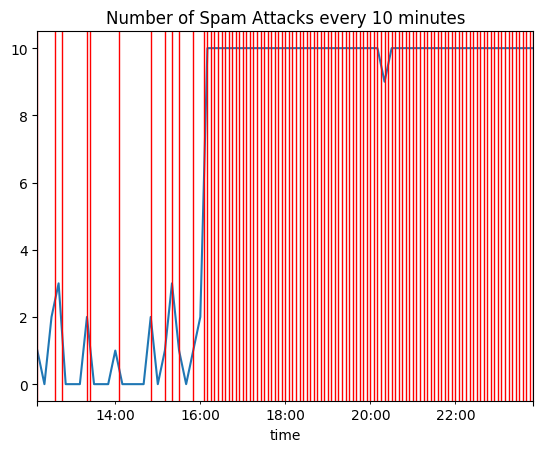

In [26]:
plt.title('Number of Spam Attacks every 10 minutes')
ser = ser.resample('600S').sum().fillna(0)
ax = ser.plot()
for idx in df_anom.index:
    ax.axvline(idx, color='r', lw=1)

From the figure above, it is evident that most of the SPAM attacks happen in afternoon and peak in the evening.

## Graph Profiling

Same approach as before

In [27]:
width = 5 * 60 # 5 minutes
features = ['te', 'td', 'sa', 'da', 'sp', 'dp', 'pr', 'flg', 'fwd', 'stos', 'pkt', 'byt']
filename = "data/2016-06-20_100.csv"
minSup = 0.1

spam_attackers = ["42.219.156.212", "42.219.156.213", "42.219.156.214", "42.219.156.215", "42.219.156.223"]

In [28]:
def readcsvAndGroup(filename):
    '''
    WARNING: Slow operation
    '''
    df = pd.read_csv(filename)
    df_binned = timeBin(df, width)
    df_groups = [(timeBinToDate(i, width), x) for i, x in df_binned.groupby('timebin')]
    return df_groups

In [29]:
df = pd.read_csv(filename)
df_binned = timeBin(df, width) 
df_groups = [(timeBinToDate(i, width), x) for i, x in df_binned.groupby('timebin')]

FileNotFoundError: File b'data/2016-06-20_100.csv' does not exist

In [30]:
def graphVizFromSAM(samOutput):
    '''
    undirected graph, do not differentiate between source and dest IP
    for now only used to generate images, not really sure why still using this
    '''
    g1 = gv.Graph(format='svg', engine='sfdp')

    def getId(s):
        hash_object = hashlib.sha1(str.encode(s))
        hex_dig = hash_object.hexdigest()
        return hex_dig[:8]

    for itemSet in samOutput.keys():
        sup = samOutput[itemSet]
        itemSetStr = getId(" ".join(list(itemSet)))
        supId = getId(itemSetStr)
        g1.node(supId, itemSetStr, shape='box')

        # add node
        for attr in itemSet:
            # handle ip address case
            if attr.startswith('sa') or attr.startswith('da'):
                attr = 'ip' + attr[2:]
                attrId = getId(attr)
                g1.node(attrId, attr)
                ip = attr.split(':')[1]
                if ip in spam_attackers:
                    g1.node(attrId, color = 'pink', style = 'filled')
                    g1.edge(supId, attrId, weight = str(sup), color = 'red')
                else:
                    g1.edge(supId, attrId, weight = str(sup))
            else:
                attrId = getId(attr)
                g1.node(attrId, attr)
                g1.edge(supId, attrId, weight = str(sup))
    return g1

def graphFromFIM(fim):
    G = nx.Graph()
    counter = 0
    for items, sup in fim.items():
        nodes = ["ip:"+i[3:] if i.startswith('sa') or i.startswith('da') else i
                for i in list(items)]
        G.add_nodes_from(nodes)
        
        G.add_edges_from([(node, str(counter)) for node in nodes])
        counter += 1
    return G

def connectedComponents(G):
    return list(nx.connected_component_subgraphs(G))


def emailGraph(G):
    if not G.has_node('sp:25'):
        return None
    e_g = nx.ego_graph(G, 'sp:25', 3)
    for ip in spam_attackers:
            if e_g.has_node("ip:"+ip):
                e_g.add_node("ip:"+ip, color='pink',style='filled')
    return e_g

def emailGraph2(G):
    '''
    returns CC that contains 'sp:25'
    '''
    CCs = connectedComponents(G)
    email_g = None
    e_g = [g for g in CCs if g.has_node("sp:25")]
    if len(e_g) == 1:
        e_g = e_g[0]
        e_g.add_node("sp:25", color='blue', style='filled')
        for ip in spam_attackers:
            if e_g.has_node("ip:"+ip):
                e_g.add_node("ip:"+ip, color='pink',style='filled')
        return e_g
    elif len(e_g) > 1:
        print("ERROR")
    return None

In [11]:
FIM_groups = {l: FIM(df, minSup) for l, df in df_groups}

In [99]:
# export all FIMs as hypergraphs
for l, fim in FIM_groups:
    graph = graphVizFromSAM(fim)
    graph.render('images/UGDS/2016-06-20_5min/'+str(l))

In [133]:
# (ONLY RUN WHEN EXPERIMENT PARAMS CHANGE) save FIM results in a pickle
# to_pickle = {label:fim for label, fim in FIM_groups}
# pickle.dump(to_pickle, open('pickles/2016-06-20_5min.p', 'wb'))

# resume from here next time
# FIM_groups = pickle.load( open( "pickles/2016-06-20_5min.p", "rb" ) )

In [104]:
# plot all email graphs
# for l, fim in FIM_groups.items():
#     graph = graphFromFIM(fim)
#     e = emailGraph(graph)
#     if e is not None:
#         g = to_agraph(e)
#         g.draw('images/UGDS/2016-06-20_5min_email/'+str(l)+'.png', prog='sfdp')

# plot ego graphs
for l, fim in FIM_groups_0_025.items():
    graph = graphFromFIM(fim)
    e = emailGraph(graph)
    if e is not None:
        g = to_agraph(e)
        g.draw('images/UGDS/2016-06-20_5min_email_ego3/'+str(l)+'.png', prog='sfdp')
        

## Analysis

With the minimum support of 0.1, lets see if most spam attacks appeared as a frequent itemset

In [11]:
def hasSpamAttack(fim):
    e = emailGraph(graphFromFIM(fim))
    if e is not None:
        return any(e.has_node("ip:"+ip) for ip in spam_attackers)
    return False

In [37]:
# ONLY NEED TO RUN ONCE
FIM_groups_0_1 = {l: FIM(df, 0.1) for l, df in df_groups}
FIM_groups_0_05 = {l: FIM(df, 0.05) for l, df in df_groups}
FIM_groups_0_025 = {l: FIM(df, 0.025) for l, df in df_groups}
FIM_groups_0_01 = {l: FIM(df, 0.01) for l, df in df_groups}

# pickleFIMGroup(FIM_groups_0_1, "s_0_1")
# pickleFIMGroup(FIM_groups_0_05, "s_0_05")
# pickleFIMGroup(FIM_groups_0_025, "s_0_025")
# pickleFIMGroup(FIM_groups_0_01, "s_0_01")

In [26]:
def pickleFIMGroup(fimGroup, name):
    #d = {l:f for l,f in fimGroup}
    pickle.dump(fimGroup, open('pickles/2016-06-20_5min_'+name+'.p', 'wb'))

In [7]:
def openPickle(sup):
    return pickle.load(open("pickles/2016-06-20_5min_"+'s_'+str(sup).replace('.','_')+'.p', 'rb'))

FIM_groups_0_1 = openPickle(0.1)
FIM_groups_0_05 = openPickle(0.05)
FIM_groups_0_025 = openPickle(0.025)
# FIM_groups_0_01 = openPickle(0.01) # not needed since too large

In [14]:
def resample(FIM_groups):
    '''
    given dict of time steps to freq itemsets, return series of time points that
    contain SPAM IP addresses
    '''
    nSecs = str(width)+'S'
    s = pd.Series([1 if hasSpamAttack(fim) else 0 for l,fim in FIM_groups.items()],
                  [l for l,fim in FIM_groups.items()])
#     s = pd.Series(1, index=[l for l, fim in FIM_groups.items() if hasSpamAttack(fim)])
    f = s.resample(nSecs).sum().fillna(0)
    return f

fim_s_0_1 = resample(FIM_groups_0_1)
fim_s_0_05 = resample(FIM_groups_0_05)
fim_s_0_025 = resample(FIM_groups_0_025)

    
# s_0_1 = pd.Series(1, index=[l for l, fim in FIM_groups.items() 
#                         if hasSpamAttack(fim)])
# fim_s_0_1 = s_0_1.resample('600S').sum().fillna(0)

# s_0_05 = pd.Series(1, index=[l for l, fim in FIM_groups_0_05.items() 
#                         if hasSpamAttack(fim)])
# fim_s_0_05 = s_0_05.resample('600S').sum().fillna(0)

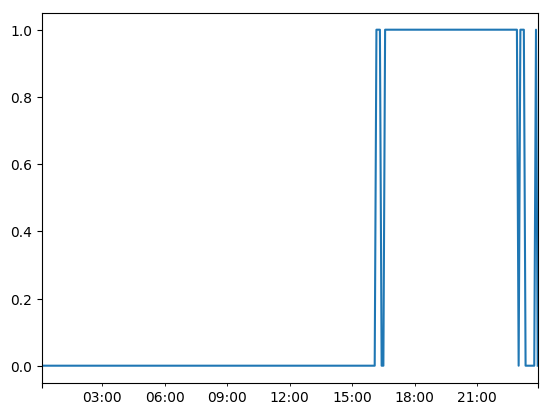

In [15]:
resample(FIM_groups_0_1).plot()

NameError: name 'ser' is not defined

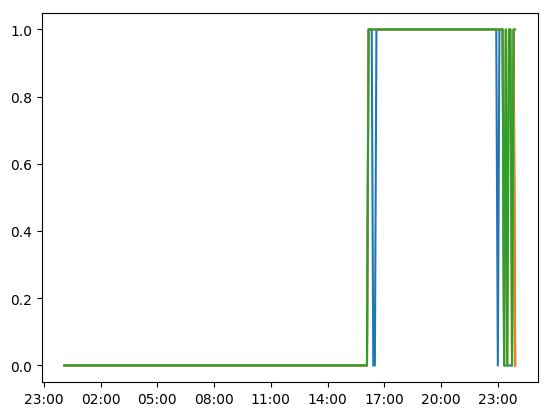

In [16]:
fig, ax = plt.subplots(nrows = 1, ncols = 1)
xfmt = md.DateFormatter('%H:%M')
ax.xaxis.set_major_formatter(xfmt)
ax.plot(fim_s_0_1.index, fim_s_0_1.data, label='FIM (0.1)')
ax.plot(fim_s_0_05.index, fim_s_0_05.data, label='FIM (0.05)')
ax.plot(fim_s_0_025.index, fim_s_0_025.data, label='FIM (0.025)')
# ax.plot(fim_s_0_01.index, fim_s_0_01.data, label='FIM (0.01)')
ax.plot(ser.index, ser.data, label='Labeled')
plt.legend()

In [245]:
s_0_025 = pd.Series(1, index=[l for l, fim in FIM_groups_0_025.items() 
                        if hasSpamAttack(fim)])
fim_s_0_025 = s_0_025.resample('600S').sum().fillna(0)

In [243]:
s_0_01 = pd.Series(1, index=[l for l, fim in FIM_groups_0_01.items() 
                        if hasSpamAttack(fim)])
fim_s_0_01 = s_0_01.resample('600S').sum().fillna(0)

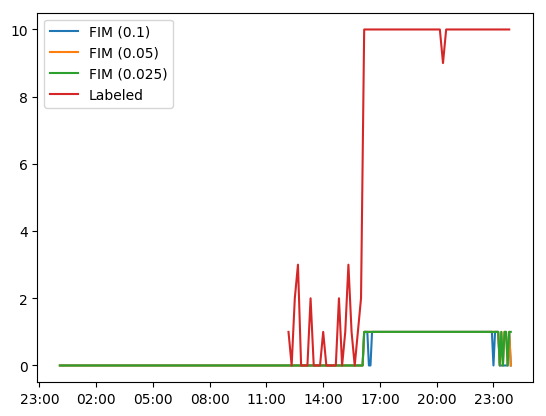

In [41]:
fig, ax = plt.subplots(nrows = 1, ncols = 1)
xfmt = md.DateFormatter('%H:%M')
ax.xaxis.set_major_formatter(xfmt)
ax.plot(fim_s_0_1.index, fim_s_0_1.data, label='FIM (0.1)')
ax.plot(fim_s_0_05.index, fim_s_0_05.data, label='FIM (0.05)')
ax.plot(fim_s_0_025.index, fim_s_0_025.data, label='FIM (0.025)')
# ax.plot(fim_s_0_01.index, fim_s_0_01.data, label='FIM (0.01)')
ax.plot(ser.index, ser.data, label='Labeled')
plt.legend()

Very weird results given that previously attacker IP addresses appeared in the FIM.

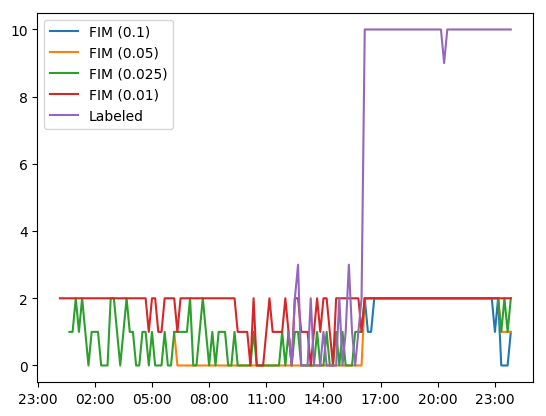

In [246]:
fig, ax = plt.subplots(nrows = 1, ncols = 1)
xfmt = md.DateFormatter('%H:%M')
ax.xaxis.set_major_formatter(xfmt)
ax.plot(fim_s_0_1.index, fim_s_0_1.data, label='FIM (0.1)')
ax.plot(fim_s_0_05.index, fim_s_0_05.data, label='FIM (0.05)')
ax.plot(fim_s_0_025.index, fim_s_0_025.data, label='FIM (0.025)')
ax.plot(fim_s_0_01.index, fim_s_0_01.data, label='FIM (0.01)')
ax.plot(ser.index, ser.data, label='Labeled')
plt.legend()

From the graph above, a support level of 0.025 seems the most appropriate. 

## SVM Anomaly Detection

In [17]:
Astart = datetime.datetime(2016, 6, 20, 9, 0)
Aend =   datetime.datetime(2016, 6, 20, 10, 55)

Bstart = datetime.datetime(2016, 6, 20, 17, 0)
Bend =   datetime.datetime(2016, 6, 20, 19, 55)

AstartIdx = next(i for i, (l, df) in enumerate(df_groups) if l==Astart)
AendIdx = next(i for i, (l, df) in enumerate(df_groups) if l==Aend)

BstartIdx = next(i for i, (l, df) in enumerate(df_groups) if l==Bstart)
BendIdx = next(i for i, (l, df) in enumerate(df_groups) if l==Bend)

# print(AstartIdx, AendIdx, BstartIdx, BendIdx)
print(df_groups[AstartIdx][0])
print(df_groups[AendIdx][0])
print(df_groups[BstartIdx][0])
print(df_groups[BendIdx][0])

NameError: name 'df_groups' is not defined

In [46]:
df_temp = df_groups[AstartIdx][1]

In [47]:
df_temp.head()

,te,td,sa,da,sp,dp,pr,flg,fwd,stos,pkt,byt,type,timebin
792244,2016-06-20 09:00:00,0.0,143.82.220.136,42.219.157.213,53,55298,UDP,.A....,0,40,1,235,background,4887948
792245,2016-06-20 09:00:00,0.0,189.82.76.9,42.219.146.245,80,61385,TCP,.A..S.,0,0,1,44,blacklist,4887948
792246,2016-06-20 09:00:00,0.0,189.82.76.9,42.219.146.60,80,45017,TCP,.A..S.,0,0,1,44,background,4887948
792247,2016-06-20 09:00:00,0.0,189.82.76.9,42.219.152.218,80,49149,TCP,.A..S.,0,0,1,44,blacklist,4887948
792248,2016-06-20 09:00:00,0.0,189.82.76.9,42.219.155.165,80,45051,TCP,.A..S.,0,0,1,44,blacklist,4887948


In [48]:
def H(s): return sum([-p_x*math.log(p_x,2) for p_x in [n_x/len(s) for x,n_x in collections.Counter(s).items()]])

In [89]:
H_sa_series = pd.Series([H(df['sa'].tolist()) for l,df in df_groups], index=[l for l,df in df_groups])
H_da_series = pd.Series([H(df['da'].tolist()) for l,df in df_groups], index=[l for l,df in df_groups])
vol_series = pd.Series([df['byt'].sum() for l,df in df_groups], index=[l for l,df in df_groups])

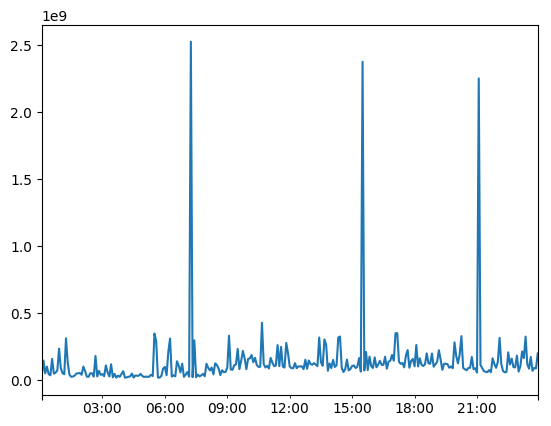

In [92]:
vol_series.plot()

In [96]:
vol_series[vol_series > 1000000000]

2016-06-20 07:15:00    2525073248
2016-06-20 15:30:00    2375630556
2016-06-20 21:05:00    2251311931
dtype: int64

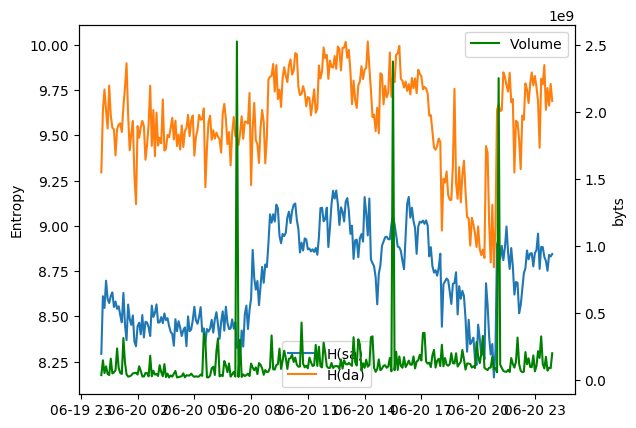

In [110]:
# fig, ax = plt.subplots(nrows = 1, ncols = 1)
fig = plt.figure()
ax =fig.add_subplot(111)
xfmt = md.DateFormatter('%H:%M')
ax.xaxis.set_major_formatter(xfmt)

ax.plot(H_sa_series.index, H_sa_series.data, '-', label='H(sa)')
ax.plot(H_da_series.index, H_da_series.data, '-', label='H(da)')
ax.set_ylabel("Entropy")
ax.legend(loc=0)

ax2 = ax.twinx()
ax2.plot(vol_series.index, vol_series.data, label='Volume',color='g')
ax2.set_ylabel("byts")
ax2.legend(loc=0)

plt.show()

# Graph Exploration

Lets see a graph that captures a SPAM attack and see what features can be extracted from it

Attack: 16:25
Normal: 13:35

Both graphs exhibit similar structure.

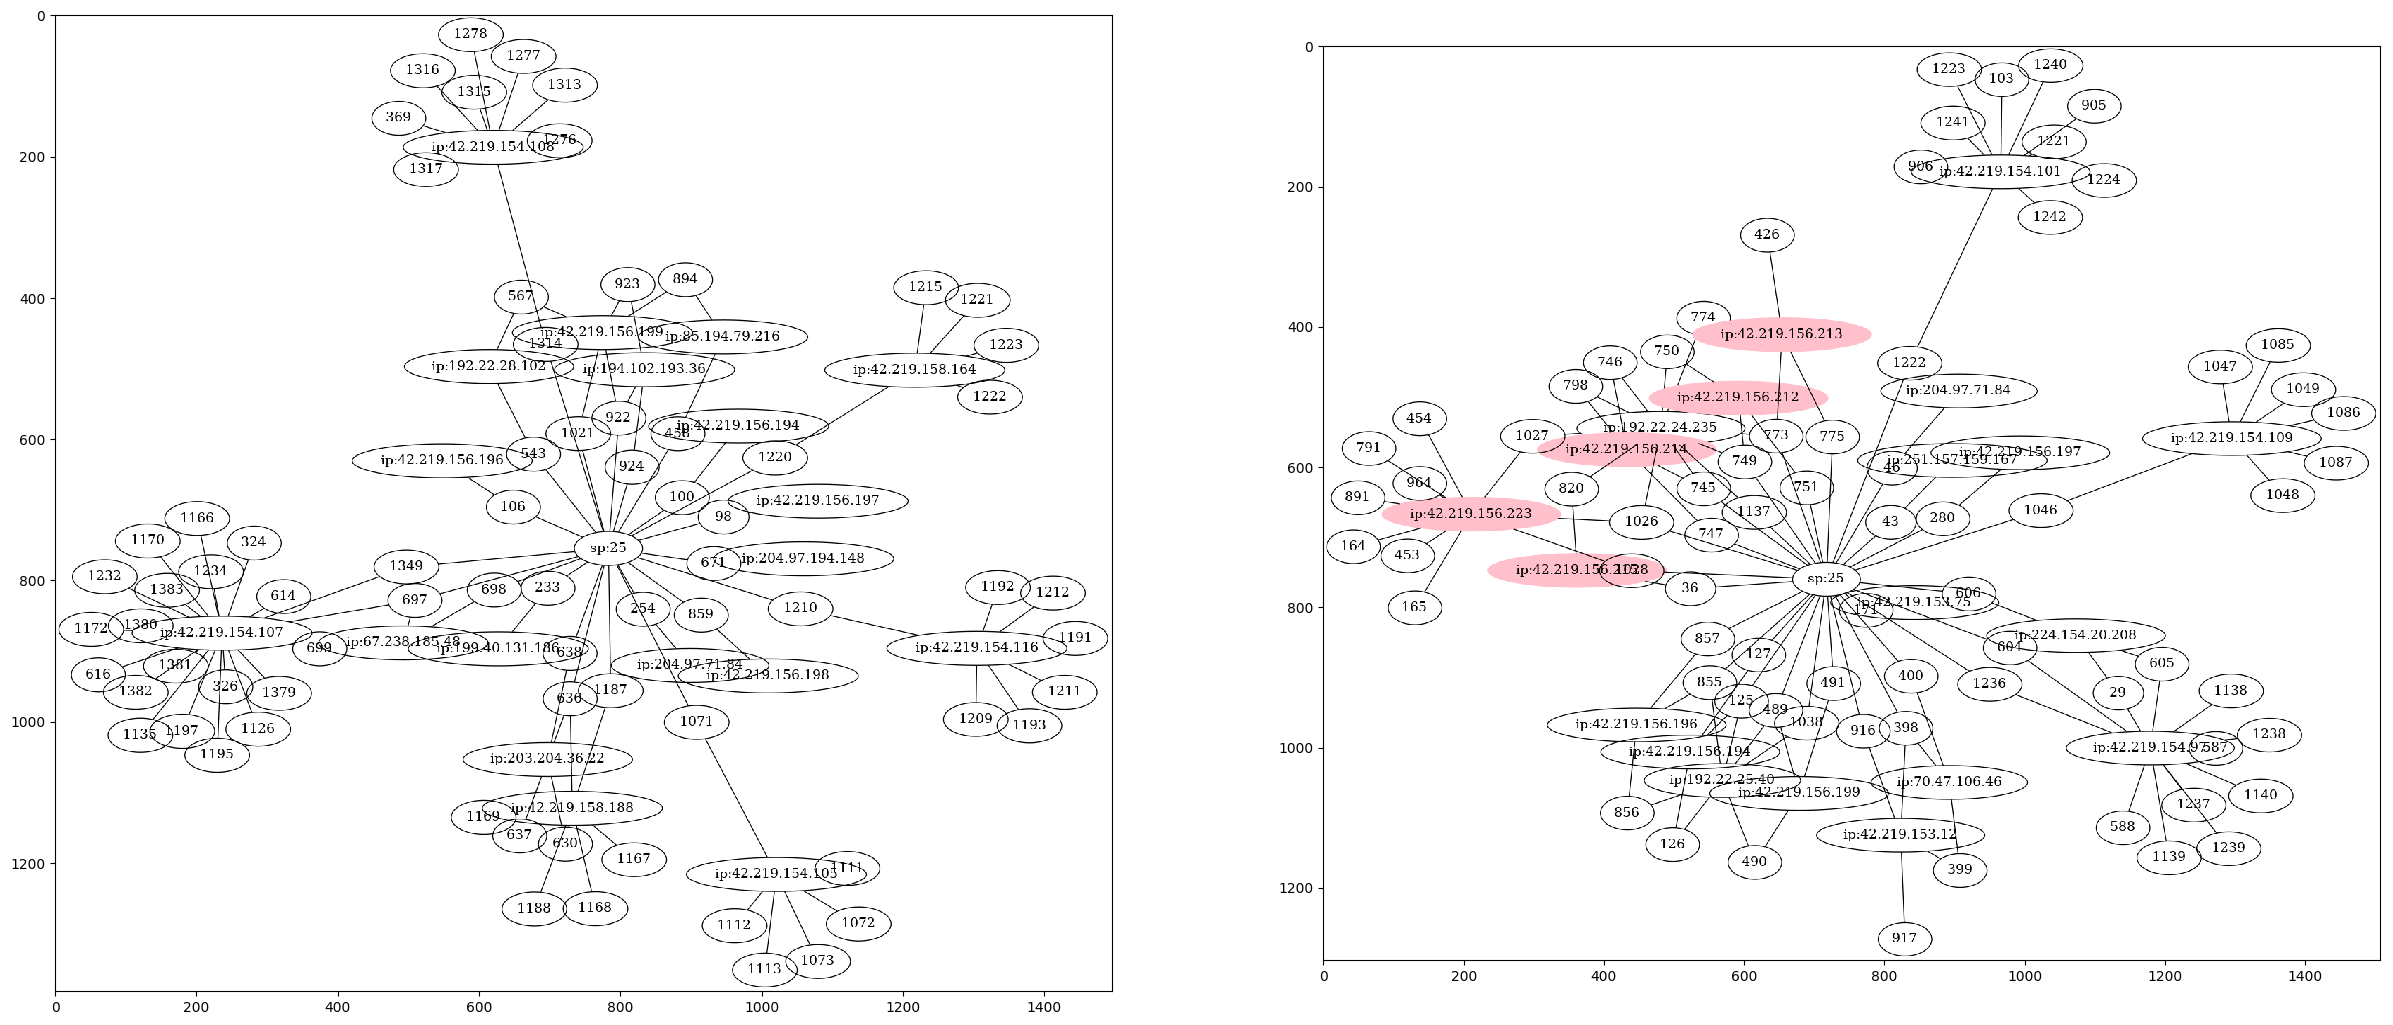

In [3]:
import matplotlib.image as mpimg
normal_img=mpimg.imread('images/UGDS/2016-06-20_5min_email_ego3/2016-06-20 13:35:00.png')
spam_img=mpimg.imread('images/UGDS/2016-06-20_5min_email_ego3/2016-06-20 16:25:00.png')

f, axarr = plt.subplots(1,2, figsize=(30, 16), dpi=100)
axarr[0].imshow(normal_img)
axarr[1].imshow(spam_img)

In [4]:
f.savefig('test.png', bbox_inches='tight')

What we notice is that there is a high degree of connectivity between attack IP addresses

### Feature extraction from graphs

In [42]:
def graphsFromFIMGroup(fg): return {l:emailGraph(graphFromFIM(f)) for l,f in fg.items()}

FIM_graphs_0_1 = graphsFromFIMGroup(FIM_groups_0_1)
FIM_graphs_0_05 = graphsFromFIMGroup(FIM_groups_0_05)
FIM_graphs_0_025 = graphsFromFIMGroup(FIM_groups_0_025)

In [43]:
# features
def avgDeg(G): return np.mean([G.degree(n) for n in G.nodes()])
def varDeg(G): return np.var([G.degree(n) for n in G.nodes()])
# runtime warnings :/
def personCorr(G): return nx.degree_pearson_correlation_coefficient(G)
def degAssortCoef(G): return nx.degree_assortativity_coefficient(G)

In [44]:
def timeLabels(FIM_graphs):
    return [l for l,g in FIM_graphs.items() if g is not None]
def featureDataSeries(FIM_graphs, f):
    return [f(g) for l,g in FIM_graphs.items() if g is not None]
tLabels = timeLabels(FIM_graphs_0_1)

aDeg = featureDataSeries(FIM_graphs_0_1, avgDeg)
vDeg = featureDataSeries(FIM_graphs_0_1, varDeg)
dACoef = featureDataSeries(FIM_graphs_0_1, degAssortCoef)
# pCoef = featureDataSeries(FIM_graphs_0_1, personCorr)

/usr/lib/python3.6/site-packages/networkx/algorithms/assortativity/correlation.py:288: RuntimeWarning: invalid value encountered in double_scalars
  return (xy * (M - ab)).sum() / numpy.sqrt(vara * varb)
/usr/lib/python3.6/site-packages/scipy/stats/stats.py:3021: RuntimeWarning: invalid value encountered in double_scalars
  r = r_num / r_den


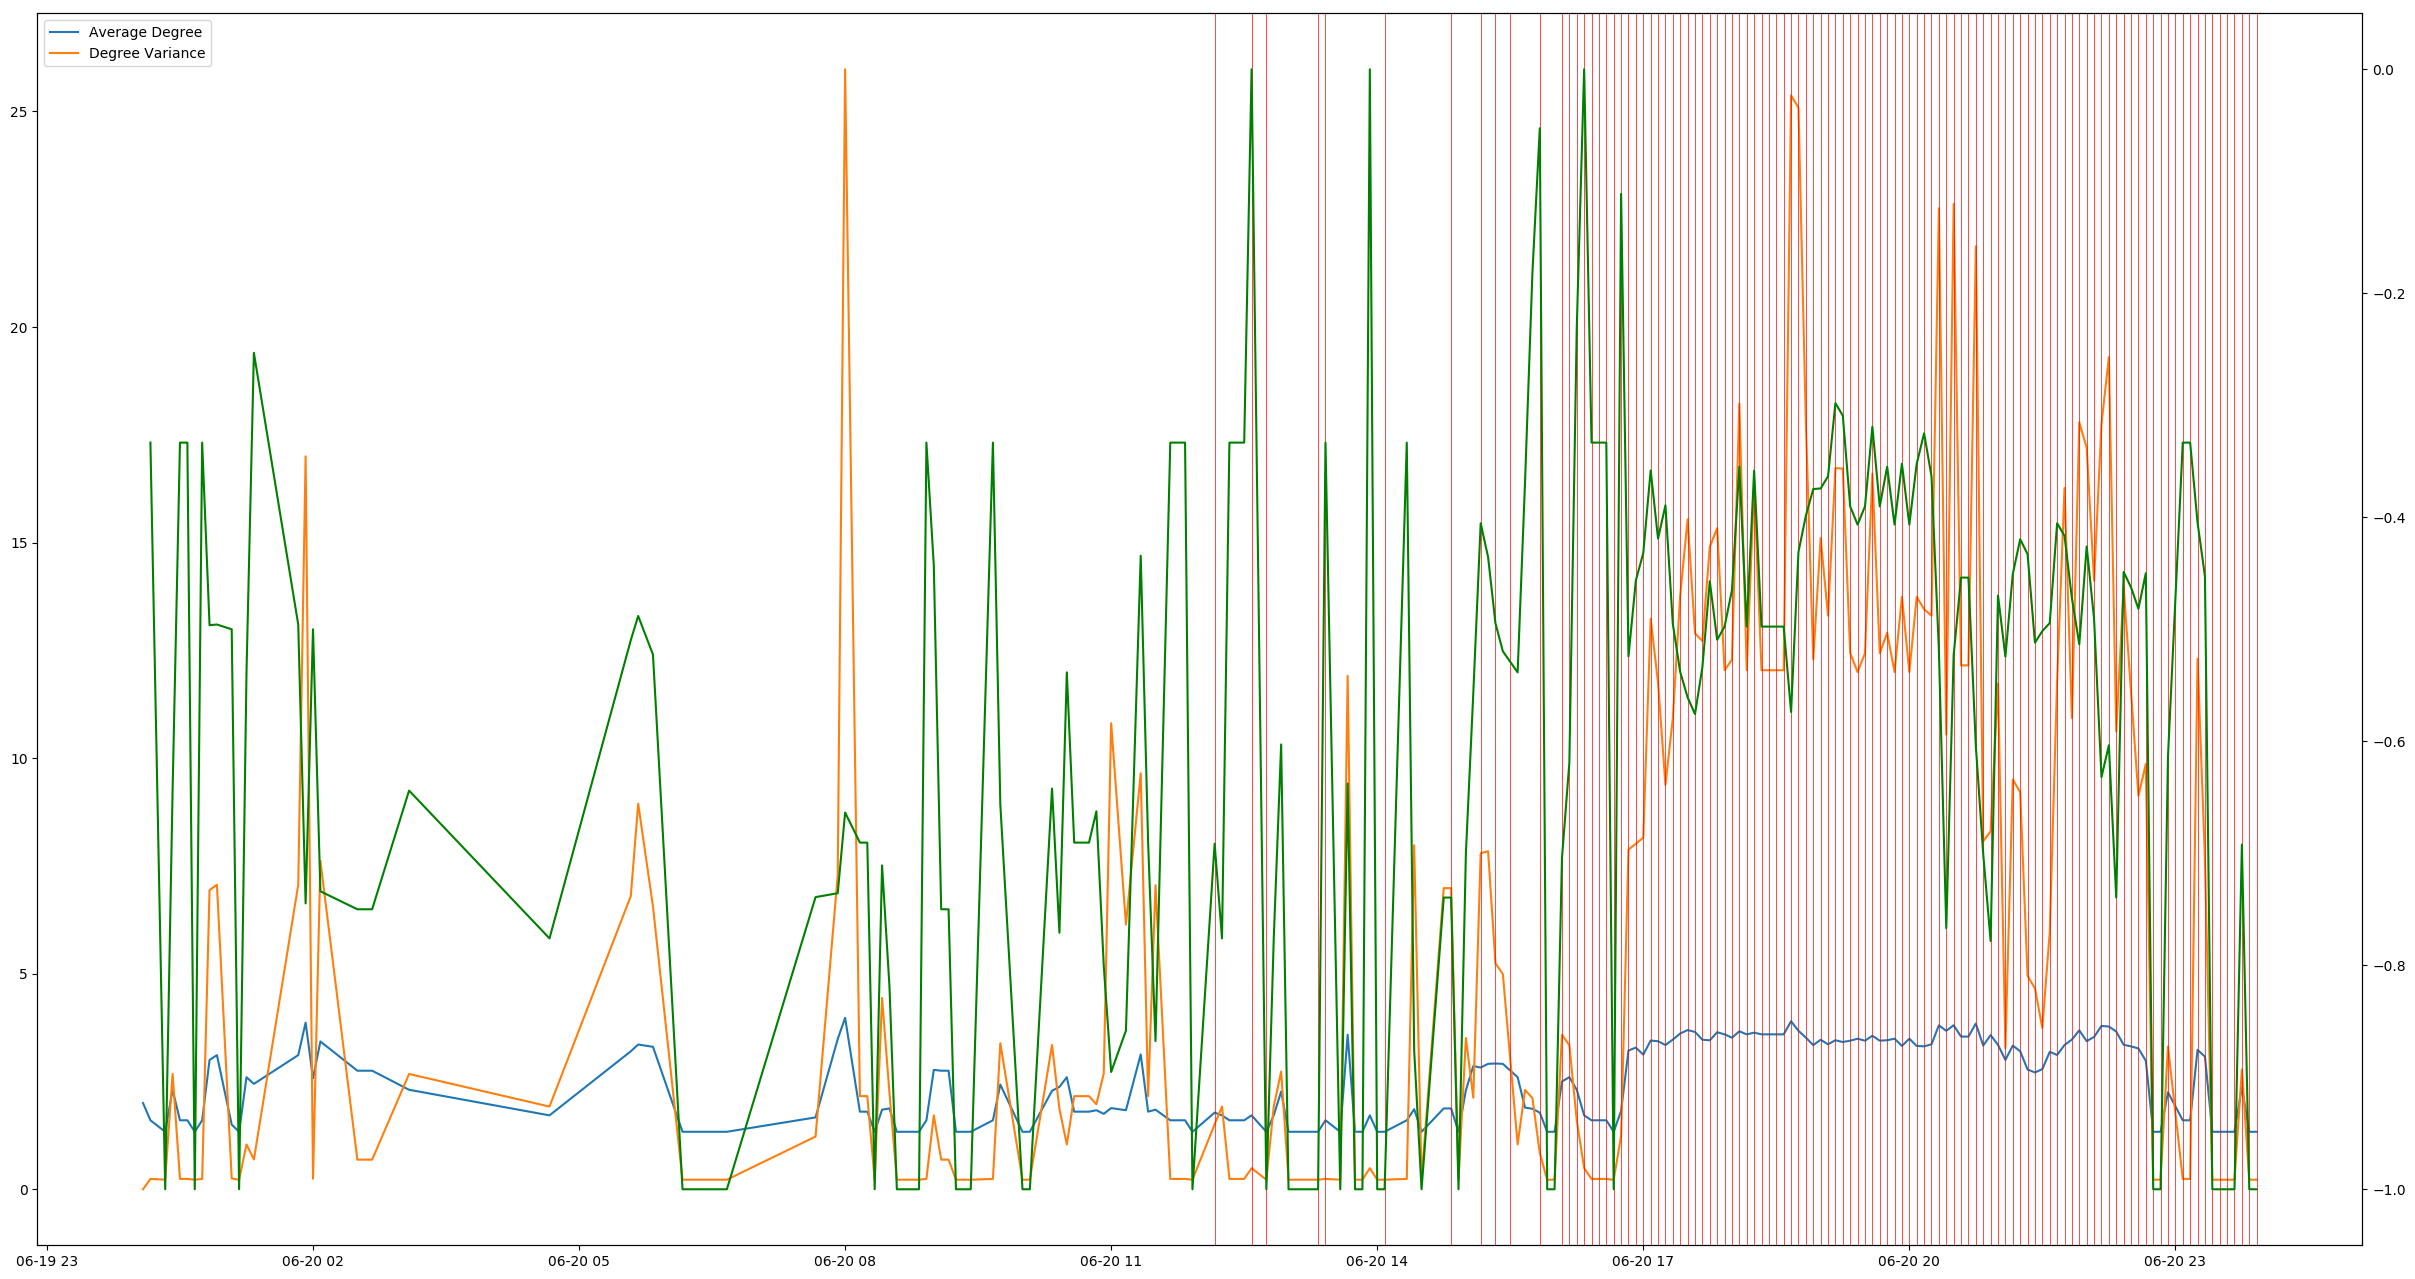

In [174]:
fig = plt.figure(figsize=(30,16))
ax =fig.add_subplot(111)
xfmt = md.DateFormatter('%H:%M')
ax.xaxis.set_major_formatter(xfmt)

ax.plot(tLabels, aDeg, '-', label='Average Degree')
ax.plot(tLabels, vDeg, '-', label='Degree Variance')

ax2 = ax.twinx()
ax2.plot(tLabels, dACoef, '-', label='Degree Association', color='g')

ax.legend(loc=0)

# ax2 = ax.twinx()
# ax2.plot(vol_series.index, vol_series.data, label='Volume',color='g')
# ax2.set_ylabel("byts")
# ax2.legend(loc=0)
for idx in df_anom.index:
    ax.axvline(idx, color='r', lw=0.5)
plt.show()

### Labeling graphs

Any graphs that contains attacker nodes and covers a spam attack will be labeled as anomalous. Anything else will be labeled as normal

In [66]:
spam_attack_times = set(df_anom.index.tolist())
normal_times = [t for t in tLabels if t not in spam_attack_times]
attack_times = [t for t in tLabels if t in spam_attack_times]

In [67]:
print("anomaly points:",len(attack_times))
print("normal points:",len(normal_times))

anomaly points: 102
normal points: 92


In [108]:
normal_indices = [next(i for i, t in enumerate(tLabels) if t == T) for T in normal_times]
attack_indices = [next(i for i, t in enumerate(tLabels) if t == T) for T in attack_times]

In [93]:
X_anom = [aDeg[i] for i in attack_indices]
Y_anom = [vDeg[i] for i in attack_indices]
Z_anom = [dACoef[i] for i in attack_indices]

X_norm = [aDeg[i] for i in nomral_indices]
Y_norm = [vDeg[i] for i in nomral_indices]
Z_norm = [dACoef[i] for i in nomral_indices]
Z_norm = [v if not isnan(v) else 0.0 for v in Z_norm]

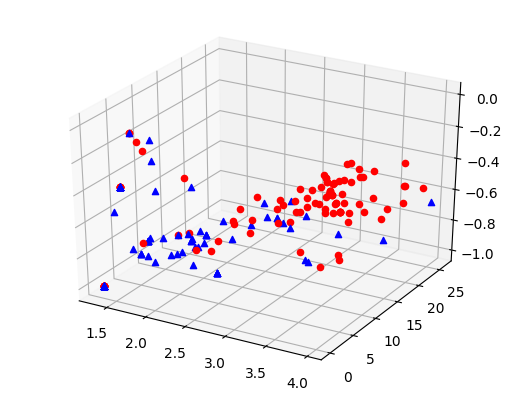

In [95]:
from mpl_toolkits.mplot3d import Axes3D
def add3dPoints(axis, X, Y, Z, c, m):
    for x,y,z in zip(X,Y,Z):
        axis.scatter(x,y,z,c=c,marker=m)
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
add3dPoints(ax,X_anom,Y_anom,Z_anom,'r','o')
add3dPoints(ax,X_norm,Y_norm,Z_norm,'b','^')

In [96]:
from sklearn import svm
X = list(zip(X_anom,Y_anom,Z_anom)) + list(zip(X_norm,Y_norm,Z_norm))
y = [1 for i in range(len(attack_indices))] + [0 for i in range(len(nomral_indices))]
clf = svm.SVC()
clf.fit(X,y)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [98]:
predicted = [clf.predict([pt]) for pt in X]

In [102]:
from sklearn.metrics import accuracy_score
accuracy_score(y, predicted, normalize=True)

0.82474226804123707

In [115]:
def computePoints(fim_graph):
    '''
    3 features: average and variance of degree and peasrson coefficient
    '''
    def replacenan(l):
        avg = np.mean(l)
        return [v if not isnan(v) else avg for v in l]
    
    aDeg = replacenan(featureDataSeries(fim_graph, avgDeg))
    vDeg = replacenan(featureDataSeries(fim_graph, varDeg))
    dACoef = replacenan(featureDataSeries(fim_graph, degAssortCoef))
    X_anom = [[aDeg[i],vDeg[i],dACoef[i]] for i in attack_indices]
    X_norm = [[aDeg[i],vDeg[i],dACoef[i]] for i in normal_indices] 
    return (X_anom, X_norm)

def plot3dScatter(X_anom, X_norm):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    def add3dPoints(axis, X, c, m):
        for x,y,z in X:
            axis.scatter(x,y,z,c=c,marker=m)
    add3dPoints(ax,X_anom,'r','o')
    add3dPoints(ax,X_norm,'b','^')
    return fig, ax

In [114]:
X_anom, X_norm = computePoints(FIM_graphs_0_1)
f, ax = plot3dScatter(X_anom, X_norm)

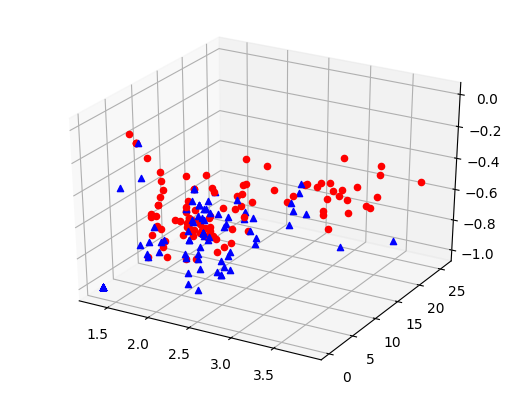

In [122]:
X_anom, X_norm = computePoints(FIM_graphs_0_05)
f, ax = plot3dScatter(X_anom, X_norm)

In [123]:
clf = svm.SVC()
clf.fit(X_anom+X_norm,y)
predicted = [clf.predict([pt]) for pt in X]
accuracy_score(y, predicted, normalize=True)

0.7010309278350515

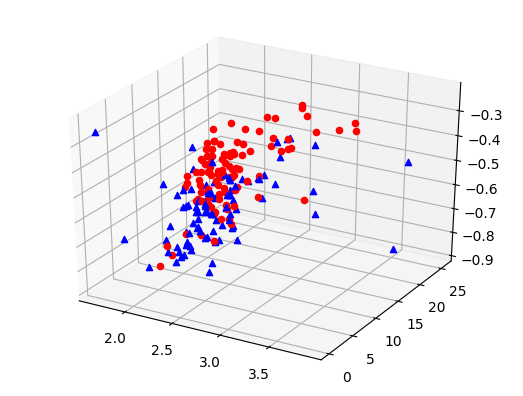

In [124]:
X_anom, X_norm = computePoints(FIM_graphs_0_025)
f, ax = plot3dScatter(X_anom, X_norm)

In [125]:
clf = svm.SVC()
clf.fit(X_anom+X_norm,y)
predicted = [clf.predict([pt]) for pt in X]
accuracy_score(y, predicted, normalize=True)

0.68041237113402064